In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils, cluster_utils, random_forest_utils

### Get stock data

In [2]:
query = """
    with raw as (
        select 
            market_datetime
            , symbol
            , open
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg(open - close) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg(high - low) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            , lead(open, 10) over (partition by symbol order by market_datetime) as open_ten_days_forward
        from td.equities)
    select * 
    from raw
    where open_ten_days_forward is not null
    and market_datetime > '2010-01-01'
    and symbol = 'AA'
    limit 1000
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,open,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,low_open_hundred_days,average_volume_hundred_days,average_volume_ten_days,average_daily_finish_ten_days,average_daily_range_ten_days,open_ten_days_forward
0,2010-01-04 06:00:00,AA,49.410000,8629779.0,40.606931,41.409412,47.250001,49.470003,34.38,1.029484e+07,8.405995e+06,-0.242725,1.314545,46.739997
1,2010-01-05 06:00:00,AA,50.490000,16642524.0,40.732277,41.591765,47.830910,50.490000,34.38,1.035548e+07,9.301152e+06,-0.106362,1.453637,46.260000
2,2010-01-06 06:00:00,AA,48.930003,15583440.0,40.844852,41.736471,48.308183,50.490000,34.38,1.039434e+07,9.813014e+06,-0.280907,1.543637,45.569997
3,2010-01-07 06:00:00,AA,49.560003,12880502.0,40.940198,41.875294,48.684547,50.490000,34.38,1.039824e+07,9.137195e+06,-0.144544,1.410000,42.540003
4,2010-01-08 06:00:00,AA,49.380003,11082063.0,41.019208,42.032942,48.921820,50.490000,34.38,1.039183e+07,9.184684e+06,-0.242726,1.483636,41.280003


### Explore data

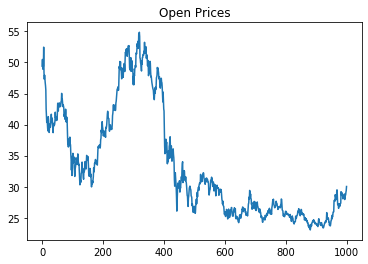

In [3]:
plt.plot(df.open)
plt.title('Open Prices')
plt.show()

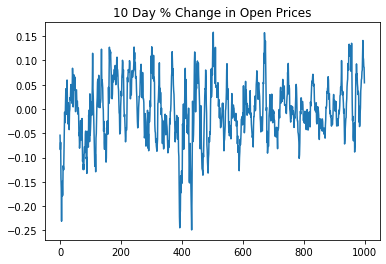

In [4]:
plt.plot((df['open_ten_days_forward'] - df['open'])/df['open'])
plt.title('10 Day % Change in Open Prices')
plt.show()

### Build random forest

#### Target: Open Price 10 Days from Now

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


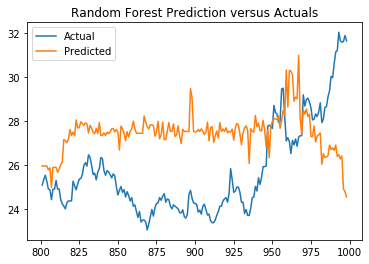

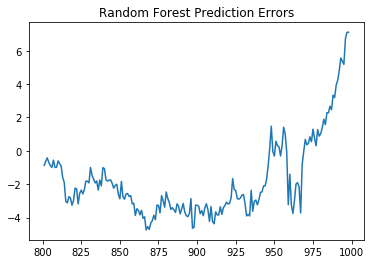

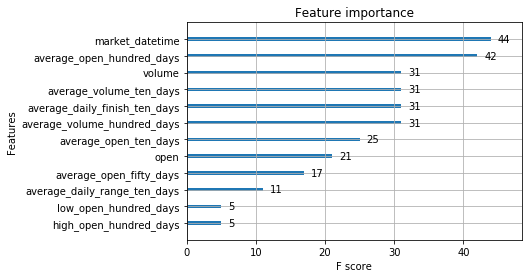

In [5]:
df['ten_day_diff'] = (df['open_ten_days_forward'] - df['open'])/df['open']

temp = df.copy()
temp['market_datetime'] = temp['market_datetime'].astype(int)

x = temp.drop(['symbol', 'open_ten_days_forward', 'ten_day_diff'], axis=1)
y = temp['open_ten_days_forward'].shift(-1)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[1:cutoff]
test_x = x.iloc[cutoff+1:-1]

train_y = y.iloc[1:cutoff]
test_y = y.iloc[cutoff+1:-1]

boost = random_forest_utils.XGBooster(train_x=train_x, 
                                      train_y=train_y,
                                      test_x=test_x, 
                                      test_y=test_y, 
                                      objective='reg:squarederror',
                                      max_depth=2,
                                      n_estimators=100
                                     )

fit_model = boost.fit()
prediction = boost.predict(model=fit_model)
mse = boost.evaluate(prediction=prediction)

boost.plot_prediction(prediction)
boost.plot_prediction_error(prediction)
boost.plot_importance(model=fit_model)

#### Target: 10 Day % Difference in Open Price

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


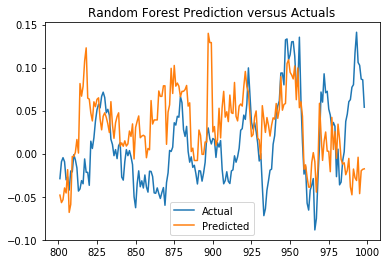

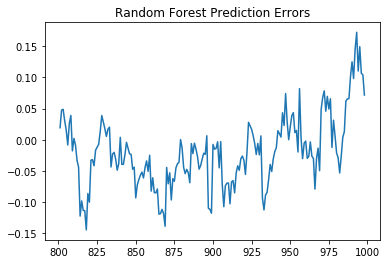

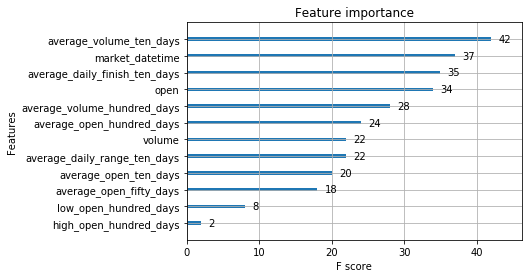

In [6]:
df['ten_day_diff'] = (df['open_ten_days_forward'] - df['open'])/df['open']

temp = df.copy()
temp['market_datetime'] = temp['market_datetime'].astype(int)

x = temp.drop(['symbol', 'open_ten_days_forward', 'ten_day_diff'], axis=1)
y = temp['ten_day_diff'].shift(-1)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[1:cutoff]
test_x = x.iloc[cutoff+1:-1]

train_y = y.iloc[1:cutoff]
test_y = y.iloc[cutoff+1:-1]

boost = random_forest_utils.XGBooster(train_x=train_x, 
                                      train_y=train_y,
                                      test_x=test_x, 
                                      test_y=test_y, 
                                      objective='reg:squarederror',
                                      max_depth=2,
                                      n_estimators=100
                                     )

fit_model = boost.fit()
prediction = boost.predict(model=fit_model)
mse = boost.evaluate(prediction=prediction)

boost.plot_prediction(prediction)
boost.plot_prediction_error(prediction)
boost.plot_importance(model=fit_model)